In [ ]:
!pip install "granite-tsfm[notebooks]==0.2.23"

In [ ]:
import pandas as pd
import torch
from tsfm_public import TinyTimeMixerForPrediction, TimeSeriesForecastingPipeline, TimeSeriesPreprocessor
from sklearn.preprocessing import StandardScaler
from datasets import Dataset
import numpy as np

# Constants
COST_PER_KWH = 8.0
CARBON_PER_KWH = 0.82

In [ ]:
df = pd.read_csv("train_wo_24_hr.csv", parse_dates=["timestamp"])
df = df.rename(columns={"target:Power": "total_load_actual"})

# Get last 96 hours for context
context_df = df.sort_values("timestamp").iloc[-96:].copy()

# Set the forecast horizon
horizon = 24  # change to 24*7 for a week

In [ ]:
# Prepare the input frame
future_index = pd.date_range(
    start=context_df["timestamp"].iloc[-1] + pd.Timedelta(hours=1),
    periods=horizon,
    freq="H"
)
future_df = pd.DataFrame({
    "timestamp": future_index,
    "total_load_actual": pd.NA
})

input_df = pd.concat([
    context_df[["timestamp", "total_load_actual"]],
    future_df
]).reset_index(drop=True)

/tmp/ipython-input-16-2339145634.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(
/tmp/ipython-input-16-2339145634.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  input_df = pd.concat([


In [ ]:
# Load model and pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",
    num_input_channels=1
)
pipeline = TimeSeriesForecastingPipeline(
    model=model,
    timestamp_column="timestamp",
    id_columns=[],
    target_columns=["total_load_actual"],
    explode_forecasts=True,
    freq="h",
    device=device
)

Device set to use cpu


In [ ]:
tsp = TimeSeriesPreprocessor(
    timestamp_column="timestamp",
    id_columns=[],
    target_columns=["total_load_actual"],
    context_length=96,
    prediction_length=24,
    scaling=True,
    scaling_type="standard"
)

# 2) Train on your full dataset
train_ds = Dataset.from_pandas(df, preserve_index=False)
tsp.train(train_ds)

TimeSeriesPreprocessor {
  "categorical_columns": [],
  "categorical_encoder": null,
  "conditional_columns": [],
  "context_length": 96,
  "control_columns": [],
  "encode_categorical": true,
  "feature_extractor_type": "TimeSeriesPreprocessor",
  "freq": "0 days 01:00:00",
  "frequency_mapping": {
    "10min": 4,
    "15min": 5,
    "2min": 2,
    "30min": 6,
    "5min": 3,
    "D": 8,
    "H": 7,
    "W": 9,
    "d": 8,
    "h": 7,
    "min": 1,
    "oov": 0
  },
  "id_columns": [],
  "observable_columns": [],
  "prediction_length": 24,
  "processor_class": "TimeSeriesPreprocessor",
  "scale_categorical_columns": true,
  "scaler_dict": {},
  "scaler_type": "standard",
  "scaling": true,
  "scaling_id_columns": [],
  "scaling_type": "standard",
  "static_categorical_columns": [],
  "target_columns": [
    "total_load_actual"
  ],
  "target_scaler_dict": {
    "0": {
      "copy": true,
      "feature_names_in_": [
        "total_load_actual"
      ],
      "mean_": [
        36303.52

In [ ]:
# Estimation
def estimate_cost(values): return sum(values) * COST_PER_KWH
def estimate_carbon(values): return sum(values) * CARBON_PER_KWH
def estimate_from_forecast(forecast_df):
    values = forecast_df["forecasted_power"].tolist()
    return {
        "cost": estimate_cost(values),
        "carbon": estimate_carbon(values)
    }

In [ ]:
# metrics = estimate_from_forecast(forecast_df)

# # Output
# print(forecast_df)
# print(metrics)

In [ ]:
def forecast_energy(df, periods: int = 12, freq: str = "5min") -> pd.DataFrame:
    # 1) Normalize freq so Timedelta always sees a number
    freq_str = freq if freq[0].isdigit() else f"1{freq}"
    delta = pd.Timedelta(freq_str)

    # 2) Pull last 96 hours of history
    context_df = df.sort_values("timestamp").copy()
    context_window = int(pd.Timedelta(hours=96) / delta)
    history = context_df.iloc[-context_window:].copy()

    # === 🔥 Normalize history ===
    mean = history["total_load_actual"].mean()
    std = history["total_load_actual"].std()
    history["total_load_actual"] = (history["total_load_actual"] - mean) / std

    # 3) Build future timestamps
    future_index = pd.date_range(
        start=history["timestamp"].iloc[-1] + delta,
        periods=periods,
        freq=freq_str
    )
    future_df = pd.DataFrame({
        "timestamp": future_index,
        "total_load_actual": pd.NA
    })

    # 4) Combine context + future
    inp = pd.concat([
        history[["timestamp", "total_load_actual"]],
        future_df[["timestamp", "total_load_actual"]]
    ], ignore_index=True)

    # 5) Run the pipeline
    results = pipeline(inp)

    # 6) Extract and denormalize predictions
    forecast_df = results.tail(periods).rename(
        columns={"total_load_actual": "forecasted_power"}
    )
    forecast_df["forecasted_power"] = forecast_df["forecasted_power"] * std + mean  # 🧠 Denormalize

    return forecast_df

In [ ]:
import matplotlib.pyplot as plt

def plot_forecast(df, title):
    plt.figure(figsize=(12, 4))
    plt.plot(df["timestamp"], df["forecasted_power"], label="Forecast", marker="o")
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Timestamp")
    plt.ylabel("Power (kW)")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()


In [ ]:
forecast_5min  = forecast_energy(df, periods=12,       freq="5min")
forecast_hour  = forecast_energy(df, periods=1,        freq="h")    # now works!
forecast_day   = forecast_energy(df, periods=24,       freq="h")
forecast_week  = forecast_energy(df, periods=24 * 7,   freq="h")
print(forecast_day)

# metrics_5min = estimate_from_forecast(forecast_5min)
# metrics_hour = estimate_from_forecast(forecast_hour)
# metrics_day  = estimate_from_forecast(forecast_day)
# metrics_week = estimate_from_forecast(forecast_week)

plot_forecast(forecast_5min, "Forecast - Next Hour (5-min)")
plot_forecast(forecast_hour, "Forecast - Next Hour")
plot_forecast(forecast_day,  "Forecast - Next Day")
plot_forecast(forecast_week, "Forecast - Next Week")

In [ ]:
import pandas as pd

def compare_forecast(df: pd.DataFrame, pipeline, period: int = 24, freq: str = "h") -> pd.DataFrame:
    # 1. Ensure UTC
    if df["timestamp"].dt.tz is None:
        df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")
    else:
        df["timestamp"] = df["timestamp"].dt.tz_convert("UTC")

    # 2. Split actual vs train
    df_sorted = df.sort_values("timestamp").reset_index(drop=True)
    actual_df = df_sorted.iloc[-period:][["timestamp","total_load_actual"]].copy()
    train_df  = df_sorted.iloc[:-period].reset_index(drop=True)

    # 3. Build context + placeholders
    context = train_df.iloc[-96:][["timestamp","total_load_actual"]]
    delta = pd.Timedelta(f"1{freq}" if not freq[0].isdigit() else freq)
    future_idx = pd.date_range(
        start=context["timestamp"].iloc[-1] + delta,
        periods=period,
        freq=freq,
        tz="UTC"
    )
    future_df = pd.DataFrame({
        "timestamp": future_idx,
        "total_load_actual": pd.NA
    })

    inp = pd.concat([context, future_df], ignore_index=True)

    # 4. Run pipeline
    results = pipeline(inp)

    preds = forecast_energy(context_96, periods=period, freq=freq)

    # preds_norm is the tiny values you saw
    preds_norm = preds["total_load_actual"].values

    # Denormalize
    preds_denorm = tsp.inverse_transform(preds_norm, column="total_load_actual")

    # Replace
    preds["forecasted_power"] = preds_denorm

    # 5. Extract just the last `period` predictions
    preds = results.tail(period)[["timestamp","total_load_actual"]].rename(
        columns={"total_load_actual":"forecasted_power"}
    )

    # DEBUG: inspect slices
    print("=== DEBUG: Actual Slice ===")
    print(actual_df.tail(5))
    print("\n=== DEBUG: Predicted Slice ===")
    print(preds.tail(5))

    # 6. Rename actuals
    actual_df_loc = actual_df.rename(columns={"total_load_actual":"actual_power"})[['timestamp','actual_power']]

    # DEBUG: inspect before merge
    print("\n=== DEBUG: Before merge ===")
    print(actual_df_loc.head())
    print(preds.head())

    # 7. Merge on timestamp
    comparison_df = pd.merge(
        actual_df_loc, preds,
        on="timestamp", how="inner"
    )

    print("\n=== DEBUG: After merge ===")
    print(comparison_df.head())

    return comparison_df


In [ ]:
# # 1. Prepare actuals and context
# df_sorted = df.sort_values("timestamp").reset_index(drop=True)
# actual_24 = df_sorted.iloc[-24:].copy()   # actual Oct 31 00:00 → Oct 31 23:00

# # Take the 96 rows immediately before those 24 as context
# context_96 = df_sorted.iloc[-(24 + 96) : -24].copy()

# # 2. Forecast next 24h from that context
# pred_24 = forecast_energy(context_96, periods=24, freq="h")

# # 3. Combine actual vs. predicted into a single table
# comparison = pd.DataFrame({
#     "timestamp": actual_24["timestamp"].values,
#     "actual_power": actual_24["total_load_actual"].values,
#     "forecasted_power": pred_24["forecasted_power"].values
# })

# # 4. Plot
# plot_comparison(comparison, "Actual vs Forecast – Last 24h")

# # 5. Inspect
# print(comparison)


In [ ]:
def get_threshold_base(hour: int) -> float:
    """
    Return threshold base (buffer) in kW for a given hour of the day.
    """
    if 0 <= hour < 6:      # Early morning (midnight–6 AM)
        return 1000
    elif 6 <= hour < 8:    # Wake-up hours
        return 1500
    elif 8 <= hour < 12:   # Morning rush
        return 2000
    elif 12 <= hour < 14:  # Lunch hours
        return 3000
    elif 14 <= hour < 18:  # Afternoon work spike
        return 5000
    elif 18 <= hour < 21:  # Evening activity
        return 4000
    elif 21 <= hour < 24:  # Wind-down/night prep
        return 2500
    else:
        return 1000  # Fallback

In [ ]:
def apply_thresholds(forecast_df: pd.DataFrame) -> pd.DataFrame:
    forecast_df = forecast_df.copy()
    forecast_df["hour"] = forecast_df["timestamp"].dt.hour
    forecast_df["threshold_base"] = forecast_df["hour"].apply(get_threshold_base)
    forecast_df["threshold"] = forecast_df["forecasted_power"] + forecast_df["threshold_base"]
    return forecast_df.drop(columns=["hour"])


In [ ]:
# Step 1: Forecast for next day
forecast_day = forecast_energy(df, periods=24, freq="h")

# Step 2: Apply time-based threshold logic
forecast_with_thresholds = apply_thresholds(forecast_day)

# Display
print(forecast_with_thresholds.head())


In [ ]:
def plot_thresholds(df):
    plt.figure(figsize=(12, 5))
    plt.plot(df["timestamp"], df["forecasted_power"], label="Forecast", marker="o")
    plt.plot(df["timestamp"], df["threshold"], label="Threshold", linestyle="--", color="red")
    plt.xticks(rotation=45)
    plt.title("Forecast vs Dynamic Threshold")
    plt.ylabel("Power (kW)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
plot_thresholds(forecast_with_thresholds)

In [ ]:
def calculate_cost_and_carbon(actual_power, forecasted_power):
    # Constants
    COST_PER_KWH = 8.0         # INR
    CARBON_PER_KWH = 0.82      # kg CO2

    # Sums
    total_actual_kwh = sum(actual_power)
    total_forecast_kwh = sum(forecasted_power)

    # Cost
    actual_cost = total_actual_kwh * COST_PER_KWH
    forecast_cost = total_forecast_kwh * COST_PER_KWH

    # Carbon
    actual_carbon = total_actual_kwh * CARBON_PER_KWH
    forecast_carbon = total_forecast_kwh * CARBON_PER_KWH

    # Print
    print("=== Energy & Impact Comparison ===")
    print(f"Total Actual Energy:       {total_actual_kwh:,.2f} kWh")
    print(f"Total Forecasted Energy:   {total_forecast_kwh:,.2f} kWh\n")

    print(f"Actual Cost:               ₹{actual_cost:,.2f}")
    print(f"Forecasted Cost:           ₹{forecast_cost:,.2f}\n")

    print(f"Actual Carbon Emission:    {actual_carbon:,.2f} kg CO₂")
    print(f"Forecasted Carbon Emission:{forecast_carbon:,.2f} kg CO₂")

In [ ]:
actual_power = [
    19785.838216, 20002.627230, 20762.242276, 20996.101291, 20973.910289,
    20057.251233, 19142.299177, 35486.825182, 38033.669338, 38960.570395,
    40059.878463, 40534.424492, 37946.612333, 36522.974245, 40664.156500,
    40640.258498, 42410.417607, 42579.410618, 41311.109540, 32200.849980,
    22776.502400, 20200.639242, 20915.872286, 20598.370266
]

forecasted_power = [
    28145.894967, 27951.964851, 28005.988331, 27932.182476, 27958.055113,
    27908.063369, 27936.795245, 28752.266505, 30259.624567, 30951.488248,
    31388.198162, 31472.945875, 31248.456557, 30928.298685, 30862.596703,
    30813.779481, 31042.127407, 31151.716626, 31011.434467, 30090.836720,
    29053.361053, 28590.830346, 28453.818912, 28415.646804
]

calculate_cost_and_carbon(actual_power, forecasted_power)


=== Energy & Impact Comparison ===
Total Actual Energy:       733,562.81 kWh
Total Forecasted Energy:   710,326.37 kWh

Actual Cost:               ₹5,868,502.49
Forecasted Cost:           ₹5,682,610.97

Actual Carbon Emission:    601,521.51 kg CO₂
Forecasted Carbon Emission:582,467.62 kg CO₂


In [ ]:
from tsfm_public import TimeSeriesForecastingPipeline

pipeline_5min = TimeSeriesForecastingPipeline(
    model=model,
    timestamp_column="timestamp",
    id_columns=[],
    target_columns=["total_load_actual"],
    explode_forecasts=True,
    freq="5min",          # ← critical: 5-minute intervals
    device=device
)

Device set to use cpu


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tsfm_public import TimeSeriesForecastingPipeline

def predict_2day_5min_continuous(csv_file, model, device, output_csv="two_day_5min.csv"):
    # 1) Load & rename
    df = pd.read_csv(csv_file, parse_dates=["timestamp"])
    df.rename(columns={"target:Power": "total_load_actual"}, inplace=True)
    df = df.sort_values("timestamp").reset_index(drop=True)

    # 2) Compute sizes
    freq = "5min"
    delta = pd.Timedelta(freq)
    total_days = 2
    total_periods = int(pd.Timedelta(days=total_days) / delta)  # 576
    chunk_size = 96                                            # model max
    chunks = (total_periods + chunk_size - 1) // chunk_size   # =6

    # 3) Extract & normalize context (last 96h = 1152 points)
    context_points = int(pd.Timedelta(hours=96) / delta)
    context_df = df.iloc[-context_points:].copy()
    μ, σ = context_df["total_load_actual"].mean(), context_df["total_load_actual"].std()
    context_df["total_load_actual"] = (context_df["total_load_actual"] - μ) / σ

    all_preds = []
    last_ts = context_df["timestamp"].iloc[-1]

    for c in range(chunks):
        # how many to forecast this chunk
        remain = total_periods - c * chunk_size
        h = min(chunk_size, remain)

        # build pipeline for this chunk
        pipe = TimeSeriesForecastingPipeline(
            model=model,
            timestamp_column="timestamp",
            id_columns=[],
            target_columns=["total_load_actual"],
            explode_forecasts=False,
            freq=freq,
            device=device,
            prediction_length=h,
        )

        # build future placeholders
        future_idx = pd.date_range(
            start=last_ts + delta,
            periods=h,
            freq=freq,
            tz=last_ts.tz
        )
        future_df = pd.DataFrame({
            "timestamp": future_idx,
            "total_load_actual": pd.NA
        })

        # one‐shot forecast for h steps
        inp = pd.concat([
            context_df[["timestamp","total_load_actual"]],
            future_df
        ], ignore_index=True)
        res = pipe(inp)

        # extract, denormalize, store
        preds = res["total_load_actual_prediction"].iloc[-1]  # list of len h
        series = pd.Series(preds, index=future_idx)
        series = series * σ + μ
        all_preds.append(series)

        # extend context_df with normalized predictions for next chunk
        new_context = series.to_frame(name="total_load_actual")
        new_context["total_load_actual"] = (new_context["total_load_actual"] - μ) / σ
        new_context = new_context.reset_index().rename(columns={"index":"timestamp"})
        context_df = pd.concat([context_df, new_context], ignore_index=True)

        last_ts = future_idx[-1]

        print(f"⏳ Completed chunk {c+1}/{chunks} ({h} steps)")

    # 4) Combine all predictions
    full = pd.concat(all_preds)
    forecast_df = full.rename("forecasted_power").reset_index()
    forecast_df.columns = ["timestamp","forecasted_power"]

    # 5) Save & plot
    forecast_df.to_csv(output_csv, index=False)
    print(f"✅ Saved forecast to {output_csv}")

    plt.figure(figsize=(14,4))
    plt.plot(forecast_df["timestamp"], forecast_df["forecasted_power"], linewidth=0.8)
    plt.title("2-Day Forecast @ 5-min Intervals")
    plt.xlabel("Timestamp")
    plt.ylabel("Forecasted Power")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return forecast_df

Device set to use cpu
/tmp/ipython-input-77-2709755772.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  inp = pd.concat([
Device set to use cpu


⏳ Completed chunk 1/6 (96 steps)


/tmp/ipython-input-77-2709755772.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  inp = pd.concat([
Device set to use cpu


⏳ Completed chunk 2/6 (96 steps)


/tmp/ipython-input-77-2709755772.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  inp = pd.concat([
Device set to use cpu


⏳ Completed chunk 3/6 (96 steps)


/tmp/ipython-input-77-2709755772.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  inp = pd.concat([
Device set to use cpu


⏳ Completed chunk 4/6 (96 steps)


/tmp/ipython-input-77-2709755772.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  inp = pd.concat([
Device set to use cpu


⏳ Completed chunk 5/6 (96 steps)


/tmp/ipython-input-77-2709755772.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  inp = pd.concat([


⏳ Completed chunk 6/6 (96 steps)
✅ Saved forecast to two_day_5min.csv


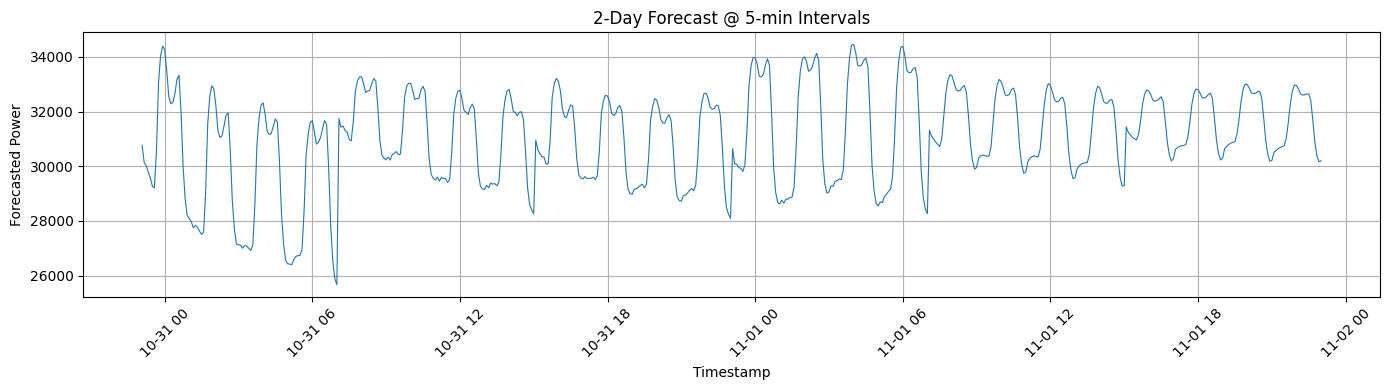

In [ ]:
forecast_2d_5min = predict_2day_5min_continuous(
    "train_wo_24_hr.csv",
    model,
    device
)

In [ ]:
# === Debug: inspect your 5-min context before forecasting ===
print("=== Context Data Sample ===")
print(context_df.tail(5))             # Last 5 rows of raw input
print("\n=== Context Data Stats ===")
print(context_df["total_load_actual"].describe())  # min/mean/std/max

# Now run your forecast
results = pipeline_5min(context_df_and_future)

=== Context Data Sample ===
                      timestamp  total_load_actual  exog:IsHoliday  exog:Hour  \
17480 2017-10-30 19:00:00+00:00       34353.377112           False         19   
17481 2017-10-30 20:00:00+00:00       22160.275362           False         20   
17482 2017-10-30 21:00:00+00:00       20931.235287           False         21   
17483 2017-10-30 22:00:00+00:00       21429.679317           False         22   
17484 2017-10-30 23:00:00+00:00       20944.891288           False         23   

       exog:DayOfWeek  exog:SimOccupancy  exog:OutdoorTemp  exog:TempDiff  
17480               0                0.5         17.840000       0.160000  
17481               0                0.5         17.000000       1.000000  
17482               0                0.2         16.666667       1.333333  
17483               0                0.2         16.780000       1.220000  
17484               0                0.2         16.333333       1.666667  

=== Context Data Stats ===
c

NameError: name 'context_df_and_future' is not defined

In [ ]:
# # 1. Load Preprocessor
# tsp = TimeSeriesPreprocessor(
#     timestamp_column="timestamp",
#     id_columns=[],
#     target_columns=["value1"],
#     control_columns=[
#         "exog:IsHoliday", "exog:Hour", "exog:DayOfWeek",
#         "exog:SimOccupancy", "exog:OutdoorTemp", "exog:TempDiff"
#     ],
#     context_length=96,
#     prediction_length=24,
#     scaling=True,
#     scaling_type="standard"
# )

# # 2. Load Model
# model = TinyTimeMixerForPrediction.from_pretrained(
#     "ibm-granite/granite-timeseries-ttm-r2",
#     num_input_channels=tsp.num_input_channels,
#     prediction_channel_indices=tsp.prediction_channel_indices,
#     exogenous_channel_indices=tsp.exogenous_channel_indices,
#     decoder_mode="mix_channel"
# )
# model.eval()

In [ ]:
# from datasets import Dataset

# def forecast_day(df_recent: pd.DataFrame):
#     """
#     Forecast next 24 hours using the latest 96 hours of data.
#     Assumes tsp and model are already loaded and ready.
#     """
#     from datasets import Dataset

#     # Convert to HuggingFace Dataset
#     recent_ds = Dataset.from_pandas(df_recent, preserve_index=False)

#     # Preprocess
#     processed_input = tsp.preprocess(recent_ds)

#     # Set format for PyTorch
#     processed_input.set_format("torch")

#     # Run model
#     with torch.no_grad():
#         outputs = model.generate(processed_input)

#     # Convert predictions to numpy
#     preds = outputs.cpu().numpy().flatten()

#     # Create forecast timestamps
#     last_timestamp = df_recent["timestamp"].iloc[-1]
#     forecast_timestamps = pd.date_range(
#         start=last_timestamp + pd.Timedelta(hours=1),
#         periods=24,
#         freq="H"
#     )

#     # Build output DataFrame
#     forecast_df = pd.DataFrame({
#         "timestamp": forecast_timestamps,
#         "value": preds  # ✅ for compatibility with estimate_from_forecast()
#     })

#     return forecast_df

In [ ]:
# def estimate_cost(values: list[float]) -> float:
#     return sum(values) * COST_PER_KWH

# def estimate_carbon(values: list[float]) -> float:
#     return sum(values) * CARBON_PER_KWH

# def estimate_from_forecast(forecast_df: pd.DataFrame) -> dict:
#     values = forecast_df["forecasted_power"].tolist()
#     return {
#         "cost": estimate_cost(values),
#         "carbon": estimate_carbon(values)
#     }


In [ ]:
# df = pd.read_csv("preprocessed_train.csv", parse_dates=["timestamp"])
# df = df.rename(columns={"target:Power": "value1"})

# # Filter required columns
# df = df[[
#     "timestamp", "value1",
#     "exog:IsHoliday", "exog:Hour", "exog:DayOfWeek",
#     "exog:SimOccupancy", "exog:OutdoorTemp", "exog:TempDiff"
# ]]

In [ ]:
# train_ds = Dataset.from_pandas(df, preserve_index=False)
# tsp.train(train_ds)

In [ ]:
# df_recent = df.sort_values("timestamp").iloc[-96:].reset_index(drop=True)

In [ ]:
# forecasted_day = forecast_day(df_recent)
# print(forecasted_day)

# metrics = estimate_from_forecast(forecasted_day)
# print(metrics)

In [ ]:
# print(df_recent.shape)
# print(df_recent.isnull().sum())
# print(df_recent.tail(3))
